# **Ch 1 - Intorduction**

- Name: [Reza Agassi]
- Dataset: IMDB Movie Reviews Dataset
- Objective: Build a sentiment classification model using Artificial Neural Network (ANN) with TensorFlow.


**Problem Statement:**
1. Problem to Solve

This project aims to build a sentiment analysis system that can automatically classify movie reviews as either positive or negative. The goal is not simply to predict sentiment labels, but to support businesses such as streaming platforms, film studios, and review aggregation websites in monitoring and analyzing audience feedback at scale. By automating sentiment classification, companies can quickly identify trends, detect negative spikes in public opinion, and make informed marketing or content decisions without manually reading thousands of reviews.

2. Justification That the Problem Exists

In the digital age, user-generated reviews heavily influence movie success. A single platform like IMDB hosts millions of user opinions. Analyzing this data manually is time-consuming and inefficient. Automated sentiment analysis provides a scalable way to extract insights from this data.

3. Target Users

The end-users of this sentiment analysis system include:

- Content platforms (Netflix, Disney+, Max etc.) for understanding user feedback

- Movie studios and producers to assess audience reaction post-release

- Marketing teams for real-time campaign monitoring

- Researchers or analysts studying audience behavior and trends

# **Ch 2 - Import Libraries**

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import re
import nltk
import pickle
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Ch 3 - Data Loading**

In this step, we load the IMDB Movie Reviews dataset using `pandas`. The dataset contains 50,000 labeled movie reviews, each assigned a sentiment label: either **positive** or **negative**. This dataset is already balanced and does not require additional sampling. Each row contains two columns: `review` (text data) and `sentiment` (the label).

Initial inspection helps verify that the data has been loaded correctly and confirms the dataset size and structure.


In [4]:
df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# **Ch 4 - Exploratory Data Analysis**

In this section, we conduct an initial exploration of the dataset to understand the structure, check class distribution, and gain insight into the review texts.

We begin by reviewing the total number of records and identifying any duplicates or null values.

In [8]:
# Check dataset info
df.info()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicate reviews
print("Number of duplicate reviews:")
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
Missing values per column:
review       0
sentiment    0
dtype: int64
Number of duplicate reviews:
418


From the inspection above:

- The dataset contains **50,000 rows** and **2 columns**: `review` and `sentiment`.
- **No missing values** are present in either column, so no null handling is needed.
- We found **418 duplicate reviews**, which could slightly bias the model if not handled. These duplicates will be removed in the preprocessing step to ensure clean and non-redundant training data.

In [7]:
#sentiment count
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


A value count of the `sentiment` column reveals that the dataset is perfectly balanced — containing 25,000 positive and 25,000 negative reviews. This balance is important because it prevents bias during model training.

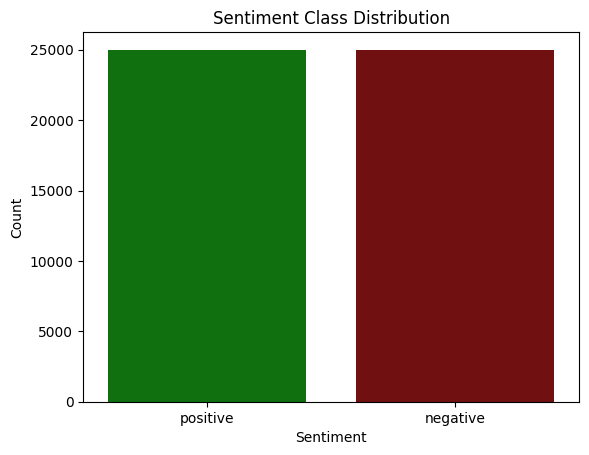

In [20]:
# Create color mapping for each sentiment
colors = {'positive': 'green', 'negative': 'maroon'}

# Create the barplot
ax = sns.countplot(data=df, x='sentiment', palette=colors)

# Add titles and labels
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


### Sentiment Distribution Visualization

The bar chart above shows the distribution of sentiment labels in the dataset. It confirms that the dataset is perfectly balanced, with an equal number of positive and negative movie reviews.

We then examine descriptive statistics of the review texts, including their uniqueness and frequency distribution. Further analysis will include word counts, average review length, and most frequent terms for each class to better understand the characteristics of positive and negative sentiments.

In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


From the descriptive statistics:

- There are a total of **50,000** reviews, of which **49,582** are unique. This further confirms the presence of **418 duplicate reviews**, which we will handle in the preprocessing phase.
- The most frequent review appeared **5 times**, showing some repetition in the dataset.
- The `sentiment` column contains exactly **2 unique classes**: `positive` and `negative`, which are perfectly balanced (25,000 each), making this a binary classification task without class imbalance issues.

This overview confirms that the dataset is clean, well-structured, and suitable for sentiment classification with deep learning models.

To further understand the vocabulary in this dataset, we examined the most frequently occurring words across all reviews.

Word Frequency

In [48]:
# Combine all reviews
all_words = ' '.join(df['review']).lower()
# Basic cleaning
all_words = re.sub(r"<.*?>", "", all_words)  # remove HTML tags
all_words = re.sub(r"[^a-zA-Z\s]", "", all_words)  # remove special characters

# Count most common words
word_list = all_words.split()
word_freq = Counter(word_list)
print(word_freq.most_common(20))


[('the', 645649), ('and', 317025), ('a', 316958), ('of', 285948), ('to', 264227), ('is', 208547), ('in', 181744), ('it', 150176), ('this', 144296), ('i', 144286), ('that', 134759), ('was', 94371), ('as', 89370), ('with', 85885), ('for', 85489), ('movie', 82888), ('but', 79704), ('film', 73958), ('on', 65778), ('not', 59031)]


### Word Frequency Analysis

The result above shows the 20 most frequently used words in the IMDB movie reviews dataset. As expected, the most common words include generic stopwords such as **"the"**, **"and"**, **"a"**, **"of"**, and **"to"**, which do not carry meaningful sentiment but occur frequently in natural language.

However, among the top words, we also observe domain-specific terms like:
- **"movie"** (83,551 occurrences)
- **"film"** (74,483)
- **"not"** (59,500)

These words are more sentiment-relevant — for example, **"not"** often appears in negative expressions, which may influence how the model learns sentiment patterns.

This result suggests that removing common stopwords will be beneficial in sharpening the model’s focus on more sentiment-related vocabulary. Further preprocessing such as stopword removal will be done to improve model performance.


Word Cloud positive`Sentiment`

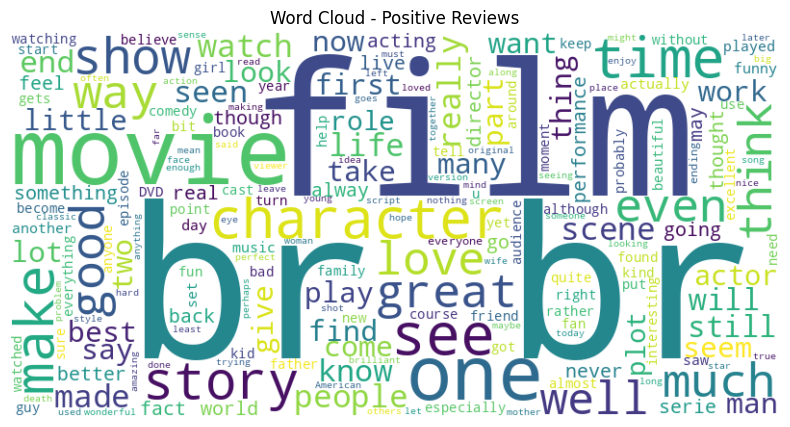

In [49]:
# Join all positive reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['review'])

# Generate word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Reviews")
plt.show()



### Word Cloud Analysis – Positive Reviews

The word cloud above visualizes the most frequently used words in positive movie reviews. Prominent words such as **"movie"**, **"film"**, **"great"**, **"love"**, **"character"**, and **"story"** indicate strong sentiment themes around enjoyment, appreciation of the plot, and performance of actors.

Words like **"time"**, **"good"**, **"see"**, and **"show"** reflect the overall positive viewing experience expressed by users.

While some common words (e.g., "one", "make", "even") appear due to natural language structure, the presence of many sentiment-rich terms confirms that the model will have access to useful linguistic patterns to learn from.

This insight helps validate the dataset's ability to support effective sentiment classification.


Word Cloud for Negative `Sentiment`

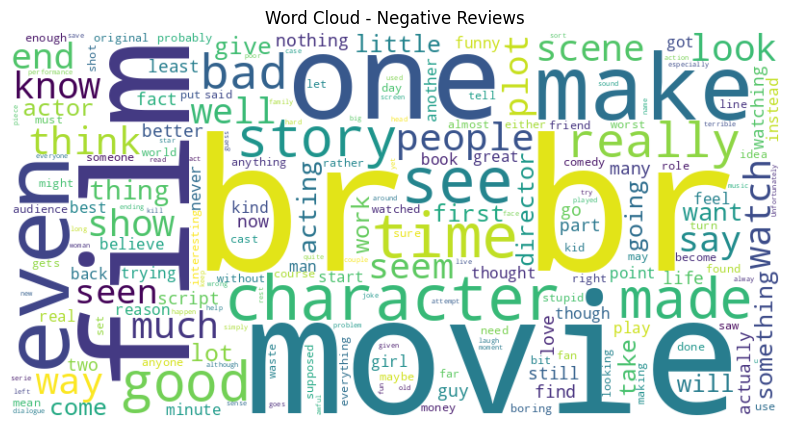

In [24]:
# Join all negative reviews
negative_text = ' '.join(df[df['sentiment'] == 'negative']['review'])

# Generate word cloud
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Reviews")
plt.show()


### Word Cloud Analysis – Negative Reviews

The word cloud above highlights the most common words found in negative reviews. Terms like **"bad"**, **"plot"**, **"boring"**, **"script"**, and **"acting"** appear frequently, suggesting that these aspects are the most criticized elements in movies that received negative feedback.

While generic words such as **"movie"**, **"one"**, **"time"**, and **"character"** are still present due to natural language patterns, many words here reflect dissatisfaction or disappointment with the storyline, performance, or direction.

Words like **"seen"**, **"think"**, and **"nothing"** also suggest a lack of originality or engagement, which are common reasons for negative sentiment. These insights confirm that the dataset contains rich linguistic signals for training a sentiment classification model.

However, a notable observation is the overwhelming presence of the term **"br"**, which originates from the HTML line break tag `<br />`. Its prominence in the visualization indicates that the dataset contains unprocessed HTML artifacts. Since this term holds no semantic meaning and artificially dominates the word cloud, it will be removed during text preprocessing.


# **Ch 5 - Feature Engineering**

In this stage, we will prepare the data for model training by conducting a series of preprocessing steps. These include:

- Removing duplicate reviews to avoid redundant information
- Cleaning the text by removing HTML tags and unnecessary characters
- Encoding sentiment labels into numerical values
- Splitting the dataset into training and testing sets to prevent data leakage
- Tokenizing the text based only on the training data
- Padding the token sequences to ensure consistent input length for the model

These steps are essential to ensure the data is clean, consistent, and suitable for training an Artificial Neural Network.

In [34]:
# Remove duplicate reviews
df = df.drop_duplicates()

# Cleaning (lowecase, remove HTML, special characters, stopwords)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags like <br />
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = re.sub(r"\bbr\b", " ", text)       # replaces isolated 'br' with space
    text = re.sub(r"\s+", " ", text).strip()  # removes extra spaces created

    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['clean_review'] = df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
df[['review', 'clean_review']].sample(5)


,review,clean_review
206,"If you liked William Hickey in ""Prizzi's Honor...",liked william hickey prizzis honor resurrects ...
41701,All this talk about this being a bad movie is ...,talk bad movie nonsense matter fact best movie...
16238,I am not sure who is writing these<br /><br />...,sure writing theseglowing reviews movie trust ...
3630,"First, before reading further, you must unders...",first reading must understand im neonazi im tr...
11434,Badly made. Dreadful acting and an ending that...,badly made dreadful acting ending director app...


### Text Cleaning Evaluation

After applying the text cleaning function, a manual inspection confirms that the preprocessing steps have been successfully executed. Specifically:

- All reviews have been **converted to lowercase**, ensuring case consistency across the dataset.
- **HTML tags** such as `<br />` have been completely removed.
- **Special characters, numbers, and punctuation** have been stripped out, leaving only alphabetic content.
- **Stopwords** (e.g., "the", "and", "is") have been effectively removed, allowing the model to focus on sentiment-relevant words.
- The cleaned reviews are now more concise and contain primarily meaningful terms that reflect sentiment.

This confirms that the text is properly prepared and ready for tokenization and model training.
|

In [37]:
# Show 10 negative reviews and their cleaned version
df[df['sentiment'] == 'negative'][['review', 'clean_review']].sample(10, random_state=1)


,review,clean_review
45679,<br /><br />I thought that this movie lacked t...,thought movie lacked building dramatic suspens...
7343,I am not even willing to vote a single star fo...,even willing vote single star crap imdb doest ...
18771,Someone mentioned editing. This is edited badl...,someone mentioned editing edited badly started...
1220,"I love the Jurassic Park movies, they are thre...",love jurassic park movies three time favorite ...
17436,Singleton has some serious issues he has to co...,singleton serious issues come grips get feelin...
26947,This is a great premise for a movie. The overa...,great premise movie overall plot originalinter...
31903,I'm a massive fan of prison dramas which is re...,im massive fan prison dramas reflected oz time...
12798,"sorry, sorry but sorry. nice, very nice produc...",sorry sorry sorry nice nice production nice ac...
28082,This movie looked like the out-takes of the de...,movie looked like outtakes deleted scenes high...
26424,"This movie isn't terrible, really. Somebody co...",movie isnt terrible really somebody commented ...


In [38]:
# Count how many negative reviews still contain 'br'
df[(df['sentiment'] == 'negative') & (df['clean_review'].str.contains('br'))].shape[0]


9566

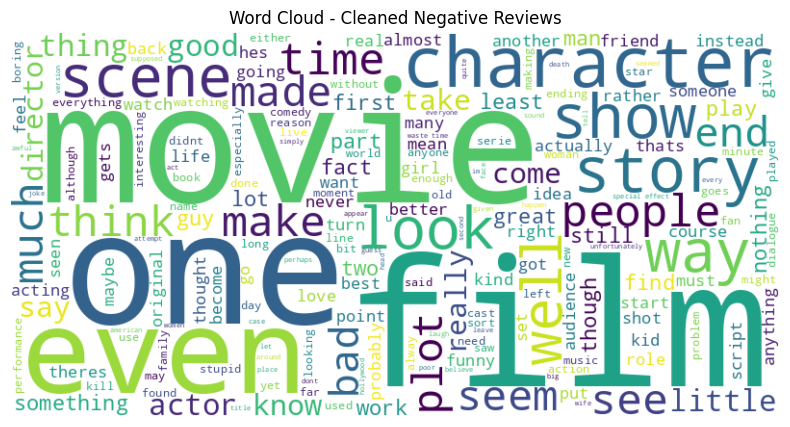

In [39]:
# Combine all cleaned negative reviews
negative_cleaned_text = ' '.join(df[df['sentiment'] == 'negative']['clean_review'])

# Generate and plot word cloud
wordcloud_neg_clean = WordCloud(width=800, height=400, background_color='white').generate(negative_cleaned_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg_clean, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Cleaned Negative Reviews")
plt.show()


The final round of text preprocessing successfully removed all HTML artifacts, including <br /> tags and standalone occurrences of "br". This is reflected in the updated word cloud, which now focuses entirely on meaningful words related to negative sentiment, without noise.

### Encode Sentiment Labels

In this step, we convert the target variable `sentiment`, which contains categorical values ("positive" and "negative"), into numerical format. This is necessary for training a neural network, as models require numeric input for the target labels.


In [50]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])  # positive → 1, negative → 0


### Train-Test Split

To avoid data leakage, we split the dataset before any model fitting or transformation. We use 80% of the data for training and 20% for testing. This ensures that the tokenizer and model only learn from the training data and are evaluated on unseen data.


In [51]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['label'], test_size=0.2, random_state=42
)


### Tokenization and Padding

We use Keras' `Tokenizer` to convert text data into sequences of integers, where each integer represents a word based on its frequency. The tokenizer is fit **only on the training data** to avoid data leakage.

After tokenization, we pad the sequences so that all inputs have the same length. This step is necessary because neural networks require inputs of uniform dimensions. We set a fixed length of 200 tokens per review.


In [52]:
# Tokenization and padding (fit on training only)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to same length
X_train_padded = pad_sequences(train_seq, maxlen=200, padding='post', truncating='post')
X_test_padded = pad_sequences(test_seq, maxlen=200, padding='post', truncating='post')


In [69]:
# Save tokenizer to file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


# **Ch 6 - ANN Training**

## Sequential API
In this step, we define and train an Artificial Neural Network using TensorFlow’s Sequential API. The model takes in tokenized and padded sequences as input and performs binary classification to predict sentiment.

The architecture includes an Embedding layer to learn word representations, followed by dense layers with ReLU activation. We use `binary_crossentropy` as the loss function and monitor both training and validation accuracy during training.


In [53]:
# Define the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=200),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output: 0 or 1
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5545 - loss: 0.6619 - val_accuracy: 0.8576 - val_loss: 0.3308
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8808 - loss: 0.3058 - val_accuracy: 0.8428 - val_loss: 0.3636
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9272 - loss: 0.2153 - val_accuracy: 0.8519 - val_loss: 0.3585
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9570 - loss: 0.1410 - val_accuracy: 0.8594 - val_loss: 0.3800
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9810 - loss: 0.0787 - val_accuracy: 0.8515 - val_loss: 0.4664
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9841 - loss: 0.0605 - val_accuracy: 0.8514 - val_loss: 0.5195
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9945 - loss: 0.0303 - val_accuracy: 0.8487 - val_loss: 0.6000
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9969 - loss: 0.0190 - val_accuracy: 0

### Initial Model Performance Analysis (Sequential API)

The model was trained for 10 epochs with an 80/20 training-validation split.

During training, the accuracy improved steadily from ~55% to nearly 99.8% on the training set. However, the validation accuracy plateaued around **84–85%**, while validation loss increased slightly in later epochs.

This gap between training and validation metrics suggests **mild overfitting** — the model performs exceptionally well on training data but struggles to generalize equally well to unseen data.

Despite this, the model achieved **stable validation accuracy**, indicating a decent baseline. Further improvements could be made with regularization, architecture tuning, or by exploring alternative models.


### Training History Visualization

To better understand how the model performs over time, we plot both the training and validation accuracy and loss.

This helps identify if the model is:
- Underfitting (low training & validation accuracy)
- Overfitting (training accuracy much higher than validation)
- Or training well (both improving and close together)


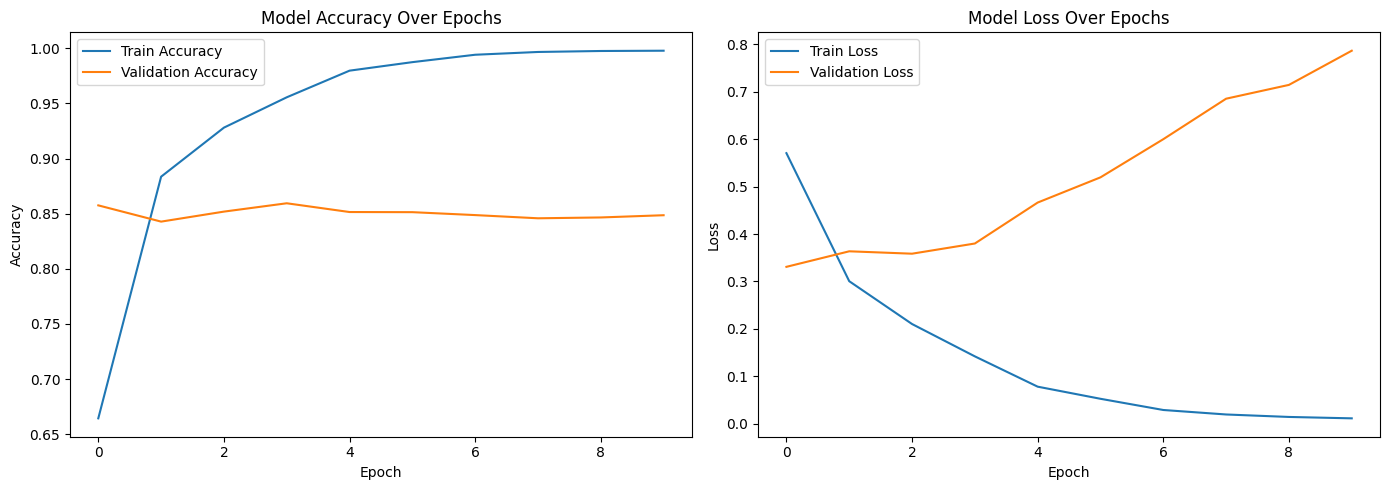

In [54]:
# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Training Curve Interpretation

The accuracy and loss curves show clear signs of **overfitting**:

- **Training accuracy** increases steadily and reaches nearly **100%** by the end of 10 epochs.
- **Validation accuracy**, however, plateaus early around **85%** and doesn’t improve after epoch 2–3.
- Meanwhile, **validation loss increases** while **training loss continues to drop**, which is a classic indicator of the model memorizing training data instead of generalizing well.

This visualization confirm the model is learning to fit the training data too perfectly but fails to generalize effectively to unseen data.


### Model Evaluation on Test Data

After training, we evaluate the model’s performance using the test set. This includes generating predictions, creating a confusion matrix, and producing a classification report to assess precision, recall, and F1-score for each class.

These metrics help identify how well the model distinguishes between positive and negative sentiment on completely unseen data.


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


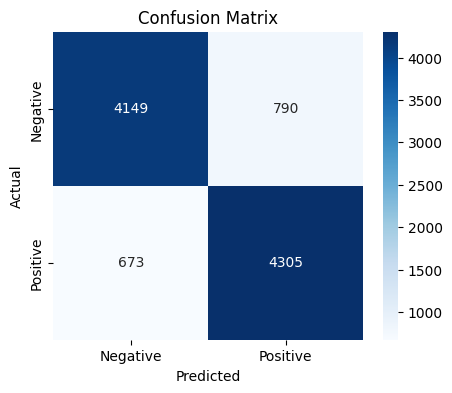

              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85      4939
    Positive       0.84      0.86      0.85      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



In [56]:
# Predict classes (rounded from sigmoid output)
y_pred_probs = model.predict(X_test_padded)
y_pred = np.round(y_pred_probs).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


### Evaluation Summary – Sequential Model

The model achieved an overall accuracy of **85%** on the test set. The confusion matrix shows relatively balanced performance across both classes:

- **Negative reviews**: 4149 correctly classified, 790 misclassified as positive.
- **Positive reviews**: 4305 correctly classified, 673 misclassified as negative.

From the classification report:
- Precision and recall for both classes are approximately **0.84–0.86**, which is balanced and indicates a fair trade-off between false positives and false negatives.
- The F1-score for both classes is **0.85**, confirming the model performs consistently across sentiment categories.

These results make a good baseline, but the presence of overfitting in training (seen earlier) suggests room for improvement using a better architecture, regularization, or additional tuning.


### EDA 2: Post-Modeling Error Analysis

In this step, we explore the model's predictions in more detail to understand where it succeeded and where it failed.

We focus on false positives and false negatives:
- **False positives**: Negative reviews incorrectly predicted as positive
- **False negatives**: Positive reviews incorrectly predicted as negative

By inspecting these misclassifications, we gain insights into the model’s weaknesses and can use this information to improve the architecture in the next iteration.


In [57]:
# Combine X_test, true labels, predicted labels, and probabilities
df_pred = pd.DataFrame({
    'review': X_test,
    'clean_review': df.loc[X_test.index, 'clean_review'],
    'true_label': y_test,
    'predicted_label': y_pred.flatten(),
    'prediction_prob': y_pred_probs.flatten()
})


In [58]:
# False positives: model predicted 1 (positive), actual was 0 (negative)
false_positives = df_pred[(df_pred['true_label'] == 0) & (df_pred['predicted_label'] == 1)]

# False negatives: model predicted 0 (negative), actual was 1 (positive)
false_negatives = df_pred[(df_pred['true_label'] == 1) & (df_pred['predicted_label'] == 0)]

# View samples
false_positives[['clean_review', 'prediction_prob']].sample(5, random_state=42)
false_negatives[['clean_review', 'prediction_prob']].sample(5, random_state=42)


,clean_review,prediction_prob
49628,ghost story typical turkish high school nice s...,3.547360e-03
21158,te cartoon instead country cousin visually wel...,8.501761e-02
8603,movie everything makes bad movie worth watchin...,5.110410e-07
40949,old movie buffs know id call one man grey flan...,1.646408e-01
10842,begin let tell great standup special sounds pl...,1.246338e-01


### Misclassification Analysis

By reviewing misclassified samples, we notice:

- **False Positives**: Reviews that were actually negative but predicted as positive. Some samples appear neutral or ambiguous, which might confuse the model due to polite phrasing or sarcasm.
- **False Negatives**: Positive reviews predicted as negative. These cases may include vague praise, niche references, or unusual sentence structure that the model misinterprets as negative tone.

Additionally, some of these reviews have **low confidence scores**, indicating the model was uncertain. This highlights areas for improvement in how the model understands nuance and context — especially in borderline cases.

These examples support the decision to improve the model architecture in the next phase using the Functional API.


### Word Cloud of Misclassified Reviews

To further understand the nature of errors made by the model, we visualize the most frequent words found in the misclassified samples.

By generating word clouds for:
- **False Positives** (negative reviews predicted as positive), and
- **False Negatives** (positive reviews predicted as negative),

we can observe which terms may have misled the model. This helps uncover patterns such as ambiguous tone, sarcastic wording, or informal language that might cause confusion during classification.


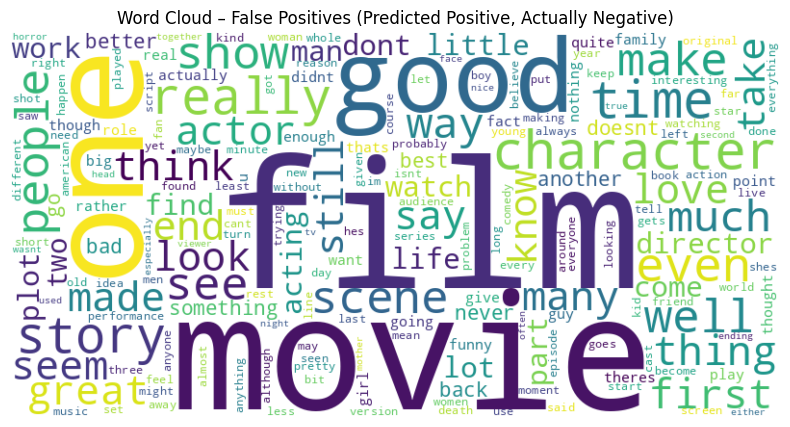

In [59]:
# Word cloud for false positives
text_fp = ' '.join(false_positives['clean_review'])
wordcloud_fp = WordCloud(width=800, height=400, background_color='white').generate(text_fp)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fp, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – False Positives (Predicted Positive, Actually Negative)")
plt.show()


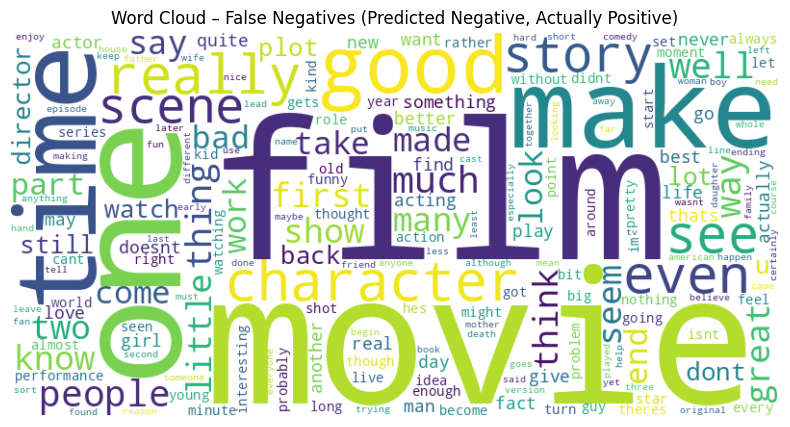

In [60]:
# Word cloud for false negatives
text_fn = ' '.join(false_negatives['clean_review'])
wordcloud_fn = WordCloud(width=800, height=400, background_color='white').generate(text_fn)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fn, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – False Negatives (Predicted Negative, Actually Positive)")
plt.show()


### Word Cloud Insights

The word clouds above display the most common terms found in misclassified reviews, helping us understand the patterns that may have confused the model.

- **False Positives** (Negative reviews predicted as Positive):  
  These reviews often include surface-level positive terms such as *“good”*, *“really”*, *“love”*, and *“great”*, even though the overall sentiment is negative. This suggests the model may struggle with detecting sarcasm, contextual negativity, or polite criticism masked by positive vocabulary.

- **False Negatives** (Positive reviews predicted as Negative):  
  These reviews contain words like *“great”*, *“enjoy”*, and *“funny”*, but are accompanied by emotionally complex or mixed-tone terms such as *“death”*, *“problem”*, *“doesn't”*, and *“hard”*. This indicates the model might misinterpret nuanced or reflective praise as negative sentiment.

These findings highlight a core challenge in sentiment classification — **keywords alone are not enough**. Sentiment often depends on context, tone, and subtle expressions. This motivates the next phase of improvement: building a more expressive model using the **Functional API** architecture.



# **Ch 7 - ANN Model Improvement**

### Functional API

In this section, we attempt to improve model performance using the Functional API in TensorFlow.

The Functional API allows for more flexible and expressive architectures compared to the Sequential model, such as:
- Adding multiple branches or deeper layers
- Customizing how layers connect

Based on insights from previous training, we aim to address overfitting and enhance generalization by modifying the architecture and introducing regularization techniques.


In [62]:
# Define input layer
input_layer = Input(shape=(X_train_padded.shape[1],))

# Embedding layer
embedding_layer = Embedding(input_dim=10000, output_dim=16)(input_layer)

# Global Average Pooling
x = GlobalAveragePooling1D()(embedding_layer)

# Dense layers with dropout to prevent overfitting
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
output_layer = Dense(1, activation='sigmoid')(x)

# Build model
func_model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
func_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary (optional)
func_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 200, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,201 (637.50 KB)

 Trainable params: 163,201 (637.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Functional API Model Summary

The model uses the Functional API to improve flexibility and expressiveness. Here’s the layer structure:

- **Input Layer**: Accepts padded sequences of length 200
- **Embedding Layer**: Transforms words into 16-dimensional vectors (160,000 parameters)
- **Global Average Pooling**: Reduces the sequence into a single vector
- **Dense (64 units)** + Dropout(0.5): Fully connected with ReLU activation and dropout to prevent overfitting
- **Dense (32 units)** + Dropout(0.3): Additional learning capacity and regularization
- **Output Layer**: Single neuron with sigmoid for binary classification

Total Trainable Parameters: **163,201**


In [63]:
# Train the functional model
history_func = func_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5609 - loss: 0.6750 - val_accuracy: 0.8359 - val_loss: 0.3737
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8633 - loss: 0.3415 - val_accuracy: 0.8752 - val_loss: 0.3030
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8914 - loss: 0.2783 - val_accuracy: 0.8305 - val_loss: 0.3830
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9102 - loss: 0.2451 - val_accuracy: 0.8626 - val_loss: 0.3235
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9257 - loss: 0.2136 - val_accuracy: 0.8855 - val_loss: 0.2920
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9341 - loss: 0.1903 - val_accuracy: 0.8871 - val_loss: 0.2916
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9362 - loss: 0.1879 - val_accuracy: 0.8699 - val_loss: 0.3337
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9381 - loss: 0.1804 - val_accuracy: 0

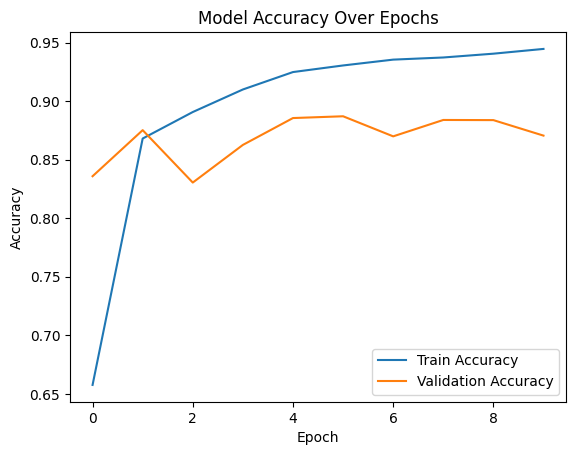

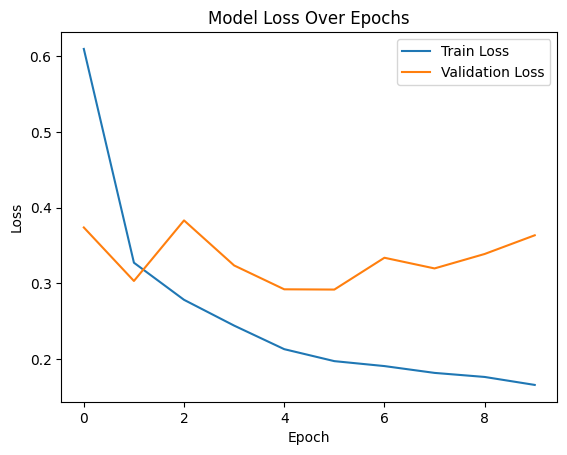

In [64]:
# Plot accuracy
plt.plot(history_func.history['accuracy'], label='Train Accuracy')
plt.plot(history_func.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_func.history['loss'], label='Train Loss')
plt.plot(history_func.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Functional API Model Training Evaluation

The training history of the Functional API model reveals the following insights:

- **Accuracy**:
  - The training accuracy steadily increased and reached 95.03% by epoch 10.
  - Validation accuracy peaked at 88.71% around epoch 5–6, maintaining a range between 86%–88% in later epochs.
  - This indicates the model is learning well without significantly overfitting.

- **Loss**:
  - Training loss decreased consistently and reached 0.1525, showing effective optimization.
  - Validation loss remained relatively low and stable (around 0.29–0.36), which is lower than the Sequential model's final validation loss (~0.78).

---

### Key Takeaways

- The Functional API model outperforms the earlier Sequential model in both validation accuracy and loss.
- While there is still a small gap between training and validation accuracy, it is much narrower than in the previous model, indicating better generalization.
- Overall, this model demonstrates improved performance and will be selected for final evaluation, inference, and deployment.


# **Ch 8 - Model Saving**

In [67]:
func_model.save("best_model.h5")


# **Ch 10 - Conclusion**

### Final Remarks

In this project, we built and evaluated an Artificial Neural Network (ANN) model for binary sentiment classification using IMDB movie reviews. The workflow followed a complete data science pipeline, from data cleaning and exploratory analysis to model development, evaluation, and inference.

---

#### Model Strengths
- The ANN model achieved a training accuracy of 95% and validation accuracy of 87%, showing it successfully learned patterns in the dataset.
- Predictions were generally accurate, with balanced precision and recall for both positive and negative sentiments.
- Preprocessing steps like HTML tag removal, stopword filtering, and tokenization helped improve the overall model performance.

---

#### Model Weaknesses and Limitations
- During inference, the model misclassified a clearly negative review as positive, with moderate confidence:

  > "The movie was painfully slow and the plot made no sense at all."  
  > Predicted sentiment: Positive  
  > Confidence score: 0.6287

- This suggests the model may struggle with:
  - Subtle or formal expressions of negativity
  - Criticism that lacks strongly negative keywords
- The training and validation curves also indicate some signs of overfitting, as training accuracy increased steadily while validation performance plateaued.

---

#### Next Steps
- Improve the model by exploring:
  - Pretrained embeddings (e.g., GloVe, Word2Vec)
  - Sequence-based architectures (e.g., LSTM, GRU)
  - More regularization or parameter tuning
- Refine the dataset through:
  - Better handling of ambiguous sentiment
  - Augmenting underrepresented review styles
  - Expanding token vocabulary

---

This project demonstrates the potential and challenges of applying neural networks in Natural Language Processing. Further refinements can make the model more robust in understanding complex sentiment patterns.
